## LSTM을 활용한 주가 예측 모델

### FinanceDataReader 설치

In [1]:
!pip install finance-datareader

### 모듈 import

In [2]:
import FinanceDataReader as fdr

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic' # 한글 폰트 설정

### 삼성전자(005930) 주가 데이터를 DataFrame으로 받아오기

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [3]:
STOCK_CODE='005930' # 삼성전자 주식코드

In [4]:
stock=fdr.DataReader(STOCK_CODE)

In [5]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-16,1191,1210,1191,1201,124980,NaN
1998-05-18,1206,1226,1165,1177,255210,-0.019983
1998-05-19,1163,1171,1118,1138,434310,-0.033135
1998-05-20,1145,1161,1126,1130,352676,-0.007030
1998-05-21,1130,1139,1061,1061,605730,-0.061062


In [7]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-15,58400,60000,58100,60000,18685583,0.043478
2022-07-18,60600,62000,60500,61900,20832517,0.031667
2022-07-19,61400,61500,60200,60900,15248261,-0.016155
2022-07-20,61800,62100,60500,60500,16782238,-0.006568
2022-07-21,61100,61800,60700,61800,10560324,0.021488


In [8]:
stock.index

DatetimeIndex(['1998-05-16', '1998-05-18', '1998-05-19', '1998-05-20',
               '1998-05-21', '1998-05-22', '1998-05-23', '1998-05-25',
               '1998-05-26', '1998-05-27',
               ...
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [14]:
len(stock.index)

6000

index가 `DatetimeIndex`로 지정되어 있다.

`DatetimeIndex`를 연,월,일로 쪼개면 **월별, 연도별 피벗데이터**를 만들 때 유용하게 활용할 수 있다.

In [9]:
stock['Year']=stock.index.year # 연
stock['Month']=stock.index.month # 월
stock['Day']=stock.index.day # 일

In [10]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-05-16,1191,1210,1191,1201,124980,NaN,1998,5,16
1998-05-18,1206,1226,1165,1177,255210,-0.019983,1998,5,18
1998-05-19,1163,1171,1118,1138,434310,-0.033135,1998,5,19
1998-05-20,1145,1161,1126,1130,352676,-0.007030,1998,5,20
1998-05-21,1130,1139,1061,1061,605730,-0.061062,1998,5,21


### 시각화

#### close열에 대한 그래프 그리기

Text(0, 0.5, 'price')

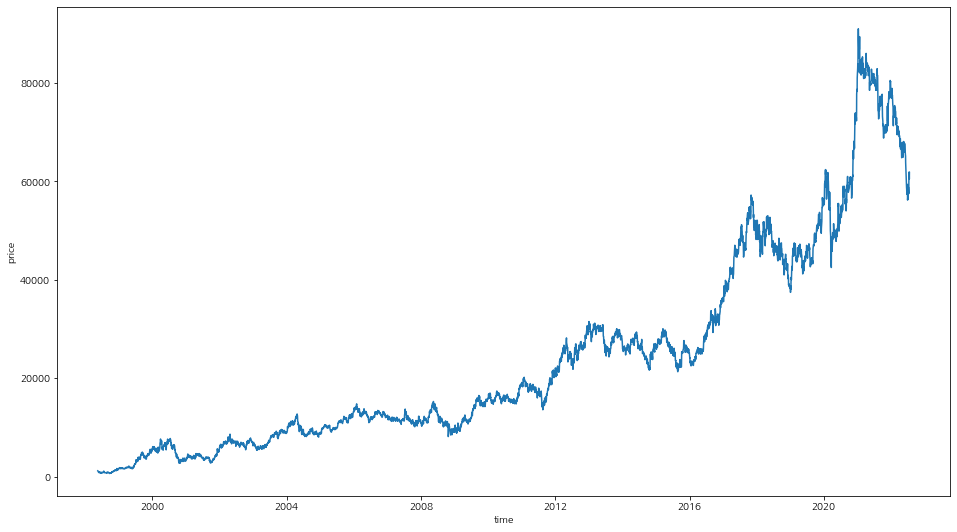

In [13]:
plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'],x=stock.index) # y:종가, x:index(날짜)
plt.xlabel('time')
plt.ylabel('price')

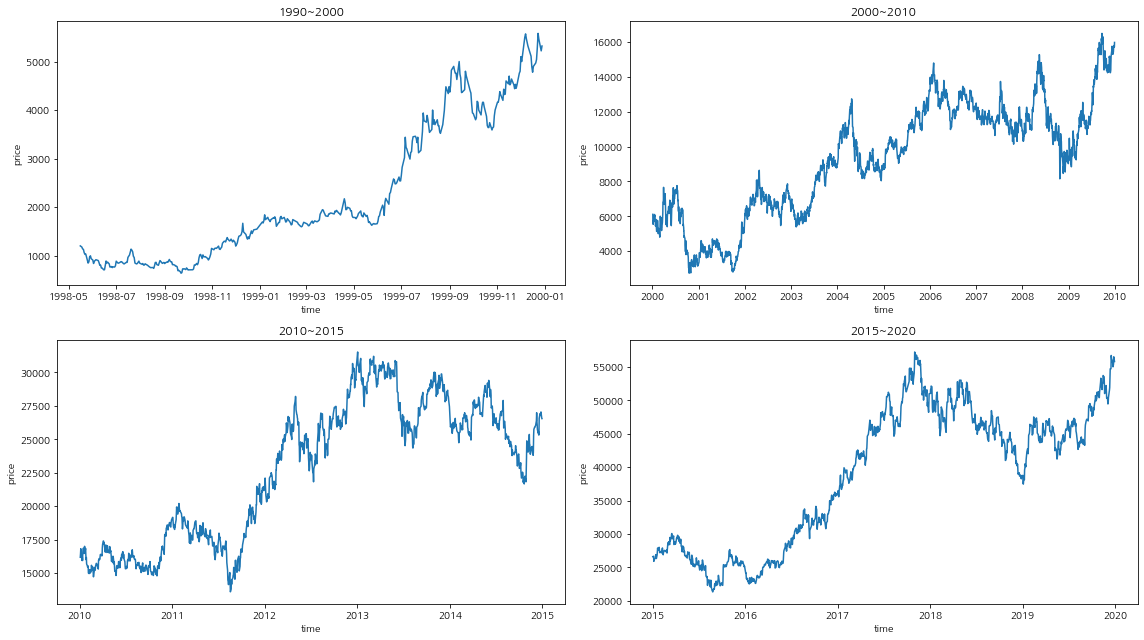

In [16]:
time_steps=[['1990','2000'], # 1990년부터 2000년
            ['2000','2010'], # 2000년부터 2010년
            ['2010','2015'], # 2010년부터 2015년
            ['2015','2020']] # 2015년부터 2020년

fig, axes=plt.subplots(2,2) # 2행 2열
fig.set_size_inches(16,9)
for i in range(4):
    ax=axes[i//2,i%2] # i=0,axes[0,0] / i=1,axes[0,1] / i=2,axes[1,0] / i=3,axes[1,1]
    df=stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])] # time_steps에서 한 개씩 불러와서 ex) 1990보다 크고 2000보다 작은 stock의 index를 가져옴
    sns.lineplot(y=df['Close'],x=df.index,ax=ax) # y=종가, x=index(날짜), ax=그래프가 그려질 위치
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}') # 제목
    ax.set_xlabel('time') # x축 이름
    ax.set_ylabel('price') # y축 이름

plt.tight_layout() # subplot들이 겹치지 않도록 최소한의 여백을 만들어줌
plt.show()

### 데이터 전처리

Open,High,Low,Close,Volume열에 대한 스케일링

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scale_cols=['Open','High','Low','Close','Volume'] # 스케일 적용할 column
scaled=scaler.fit_transform(stock[scale_cols]) # 스케일 적용
scaled

array([[0.01318937, 0.0125    , 0.01330726, 0.0062305 , 0.00138396],
       [0.01335548, 0.01266529, 0.01301676, 0.0059649 , 0.00282605],
       [0.01287929, 0.01209711, 0.01249162, 0.0055333 , 0.00480931],
       ...,
       [0.6799557 , 0.63533058, 0.6726257 , 0.66689538, 0.1688507 ],
       [0.68438538, 0.64152893, 0.67597765, 0.66246874, 0.1858371 ],
       [0.67663344, 0.63842975, 0.67821229, 0.67685532, 0.11693911]])

스케일이 완료된 column으로 새로운 데이터프레임 생성하기

6,000개의 행, 5개의 열로 이루어진 데이터셋

In [20]:
df=pd.DataFrame(scaled,columns=scale_cols)
df

,Open,High,Low,Close,Volume
0,0.013189,0.012500,0.013307,0.006230,0.001384
1,0.013355,0.012665,0.013017,0.005965,0.002826
2,0.012879,0.012097,0.012492,0.005533,0.004809
3,0.012680,0.011994,0.012581,0.005445,0.003905
4,0.012514,0.011767,0.011855,0.004681,0.006708
...,...,...,...,...,...
5995,0.646733,0.619835,0.649162,0.656935,0.206914
5996,0.671096,0.640496,0.675978,0.677962,0.230688
5997,0.679956,0.635331,0.672626,0.666895,0.168851
5998,0.684385,0.641529,0.675978,0.662469,0.185837


### train/test 분할

In [21]:
from sklearn.model_selection import train_test_split

- x: Close 열(axis=1)을 drop한 데이터프레임
- y: Close 열
- train:test 데이터비율 8:2

In [22]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('Close',1),df['Close'],test_size=0.2,random_state=0,shuffle=False)

In [23]:
x_train.shape,y_train.shape

((4800, 4), (4800,))

In [24]:
x_test.shape,y_test.shape

((1200, 4), (1200,))

In [25]:
x_train

,Open,High,Low,Volume
0,0.013189,0.012500,0.013307,0.001384
1,0.013355,0.012665,0.013017,0.002826
2,0.012879,0.012097,0.012492,0.004809
3,0.012680,0.011994,0.012581,0.003905
4,0.012514,0.011767,0.011855,0.006708
...,...,...,...,...
4795,0.530233,0.494628,0.522011,0.002490
4796,0.520709,0.488017,0.513520,0.002206
4797,0.505426,0.476033,0.504581,0.002796
4798,0.513621,0.479339,0.513520,0.001664


In [27]:
y_train

0       0.006230
1       0.005965
2       0.005533
3       0.005445
4       0.004681
          ...   
4795    0.513291
4796    0.503110
4797    0.502888
4798    0.504216
4799    0.505544
Name: Close, Length: 4800, dtype: float64

In [26]:
print(type(x_train)) # 데이터 프레임
print(type(y_train)) # 시리즈

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


## TensorFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [29]:
import tensorflow as tf

windowed_data 함수 정의

In [34]:
def windowed_dataset(series,window_size,batch_size,shuffle):
    series=tf.expand_dims(series, axis=1) # 열방향으로 1차원 확장
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+1, shift=1, drop_remainder=True)
    # WINDOW_SIZE=20이므로 +1 21개씩 그룹짓고, 한칸씩 이동, 21개 구성안되면 버리기
    ds=ds.flat_map(lambda w:w.batch(window_size+1))
    # ds 데이터프레임에서 window_size+1개만큼 꺼내온다
    if shuffle:
        ds=ds.shuffle(1000) # 1000개 섞기
    ds=ds.map(lambda w : (w[:-1],w[-1])) # 마지막거빼고 그 앞까지(~20개),마지막(21번)
    return ds.batch(batch_size).prefetch(1)

하이퍼파라미터 정의

In [35]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [37]:
train_data=windowed_dataset(y_train,WINDOW_SIZE,BATCH_SIZE,True) # 훈련데이터
test_data=windowed_dataset(y_test,WINDOW_SIZE,BATCH_SIZE,False) # 검증데이터

In [39]:
for data in train_data.take(1): # 1개를 가져옴
    print(f'데이터셋(X) 구성(batch_size,window_size,feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size,window_size,feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size,window_size,feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size,window_size,feature갯수): (32, 1)


## 모델

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [41]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [42]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt') # 파일이름
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [43]:
history = model.fit(train_data, # 훈련
                    validation_data=(test_data), # 검증 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    149/Unknown - 9s 19ms/step - loss: 7.0052e-05 - mse: 1.4010e-04
Epoch 1: val_loss improved from inf to 0.00064, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 15s 60ms/step - loss: 6.9922e-05 - mse: 1.3984e-04 - val_loss: 6.4246e-04 - val_mse: 0.0013
Epoch 2/50
148/150 [============================>.] - ETA: 0s - loss: 2.6752e-05 - mse: 5.3505e-05
Epoch 2: val_loss did not improve from 0.00064
150/150 [==============================] - 3s 21ms/step - loss: 2.6897e-05 - mse: 5.3794e-05 - val_loss: 7.9681e-04 - val_mse: 0.0016
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 2.3508e-05 - mse: 4.7016e-05
Epoch 3: val_loss improved from 0.00064 to 0.00029, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 3s 21ms/step - loss: 2.3508e-05 - mse: 4.7016e-05 - val_loss: 2.8813e-04 - val_mse: 5.7626e-04
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 2.2829e-05 - mse: 4.565

저장한 ModelCheckpoint를 로드

In [44]:
model.load_weights(filename)

test_data를 활용하여 예측

In [45]:
pred = model.predict(test_data)

37/37 [==============================] - 2s 9ms/step


In [46]:
pred.shape

(1180, 1)